# Use EUPPBench Data

In [34]:
%cd /home/ltchen/gnnpp
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms
import networkx as nx
from nbclient.client import timestamp
from torch_geometric.utils import to_networkx
from utils.data import *
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from utils.plot2 import plot_map
import networkx as nx

/home/ltchen/gnnpp


### Data Loading

In [6]:
dfs = load_dataframes(mode="train", leadtime="24h")
stations = dfs["stations"] # add orography into stations
df_target = dfs['train'][1]
df = dfs['train'][0]
df_target
df_target[df_target.time == "1997-01-02"].head()
stations.head()

[INFO] Dataframes exist. Will load pandas dataframes.


station_id     lat    lon  altitude                  name
0         235  52.928  4.781       1.2               De Kooy
1         240  52.318  4.790      -3.3              Schiphol
2         242  53.241  4.921      10.8              Vlieland
3         251  53.392  5.346       0.7  Hoorn (Terschelling)
4         260  52.100  5.180       1.9               De Bilt

In [35]:
def signed_difference(x, y): # macht es Sinn signed difference zu benutzen?
    return x - y

def dist_km(lat1: float = 0, lon1: float = 0, lat2: float = 0, lon2: float = 0) -> float:
    return geopy.distance.geodesic((lat1, lon1), (lat2, lon2)).km

def compute_mat(df: pd.DataFrame, mode: str) -> np.array:
    if mode == "geodesic":
        lon = np.array(df["lon"].copy())
        lat = np.array(df["lat"].copy())
        lon_mesh, lat_mesh = np.meshgrid(lon, lat)
        distance_matrix = np.vectorize(dist_km)(lat_mesh, lon_mesh, lat_mesh.T, lon_mesh.T)
    if mode == "altitude":
        altitude = np.array(df["altitude"].copy())
        mesh1, mesh2 = np.meshgrid(altitude, altitude)
        distance_matrix = np.vectorize(signed_difference)(mesh1, mesh2) # zwei vektoren voneinander abziehen
    if mode == "delta":
        altorog = np.array(df["alt-orog"].copy())
        mesh1, mesh2 = np.meshgrid(altorog, altorog)
        distance_matrix = np.vectorize(signed_difference)(mesh1, mesh2)
    return distance_matrix

def get_adj(dist_matrix_sliced: np.array, max_dist: float = 50) -> np.array:
    mask = None
    mask = (dist_matrix_sliced <= max_dist) & (dist_matrix_sliced >= (-max_dist))
    diagonal = np.full((mask.shape[0], mask.shape[1]), True, dtype=bool)
    np.fill_diagonal(diagonal, False)
    mask = np.logical_and(mask, diagonal)
    return mask

In [8]:
# create data object for one ensemble member (should all be the same)
date = '1997-01-02'
day = df[df.time == date]
ensemble = 0
first_ens = day[day.number == ensemble]
first_ens = first_ens.drop(columns=["time", "number"])
x = torch.tensor(first_ens.to_numpy(dtype=np.float32))

target = df_target[df_target.time == date]
target = target.drop(columns=["time", "station_id"]).to_numpy()
y = torch.tensor(target)
#print(type(target))

lon = first_ens["station_longitude"].to_numpy().reshape(-1, 1)
print(lon.shape)
lat = first_ens["station_latitude"].to_numpy().reshape(-1, 1)
print(lat.shape)
pos = np.concatenate([lon, lat], axis=1).reshape(-1, 2)
pos_dict = dict(enumerate(pos))

# Moritz has a conversion to celsius here, but should do it elsewhere (preprocess?)

(122, 1)
(122, 1)


## Altitude

### Graph 1
edges based on dist, num_attr = 1

In [9]:
max_geo = 100
geo_dist = compute_mat(dfs['stations'], "geodesic")
print(geo_dist)
geo_mask = get_adj(geo_dist, max_geo)
print(geo_mask.sum())

[[  0.          67.88302104  36.07414311 ... 717.54863254 739.55923355
  767.55524464]
 [ 67.88302104   0.         103.0930141  ... 659.66900567 683.69191062
  710.83747663]
 [ 36.07414311 103.0930141    0.         ... 743.23584479 763.87800296
  792.39252869]
 ...
 [717.54863254 659.66900567 743.23584479 ...   0.          44.37574719
   55.46816552]
 [739.55923355 683.69191062 763.87800296 ...  44.37574719   0.
   31.99306735]
 [767.55524464 710.83747663 792.39252869 ...  55.46816552  31.99306735
    0.        ]]
1420


In [10]:
geo_adj = torch.tensor(geo_mask)
geo_d = torch.tensor(geo_dist)
print(geo_d.shape)

std_geo_d = geo_d / geo_d.max()

torch.Size([122, 122])


In [11]:
# create edges
geo_edges = np.array(np.argwhere(geo_adj))
print(geo_edges.shape)
geo_edge_idx = torch.tensor(geo_edges.T) # torch.Size([1420, 2])

print(f"Edges shape: {geo_edge_idx.shape}")
print(f"Edges: {geo_edge_idx}")
print(f"Total number of edges: {np.sum(geo_adj.numpy())}")

(2, 1420)
Edges shape: torch.Size([1420, 2])
Edges: tensor([[  0,   1],
        [  0,   2],
        [  0,   3],
        ...,
        [121, 118],
        [121, 119],
        [121, 120]])
Total number of edges: 1420


In [12]:
# add attributes
geo_edge_attr = std_geo_d[geo_adj]
geo_edge_attr = torch.tensor(geo_edge_attr.reshape(-1, 1))
print(geo_edge_attr)
print(geo_edge_attr.shape)

tensor([[0.0711],
        [0.0378],
        [0.0670],
        ...,
        [0.0710],
        [0.0581],
        [0.0335]], dtype=torch.float64)
torch.Size([1420, 1])


/tmp/ipykernel_3570797/1109251601.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  geo_edge_attr = torch.tensor(geo_edge_attr.reshape(-1, 1))


In [13]:
# check sizes:
print(f"{df.station_id.nunique()} nodes and {np.sum(geo_adj.numpy())} edges")
print(f"x: {x.shape}")
print(f"edge_index: {geo_edge_idx.shape}")
print(f"edge_attr: {geo_edge_attr.shape}")
print(f"y: {y.shape}")
print(f"pos: {pos.shape}")

122 nodes and 1420 edges
x: torch.Size([122, 34])
edge_index: torch.Size([1420, 2])
edge_attr: torch.Size([1420, 1])
y: torch.Size([122, 1])
pos: (122, 2)


In [14]:
graph1 = Data(x=x, edge_index=geo_edge_idx.T, edge_attr=geo_edge_attr, timestamp=date, y=y)
#graph1
print(graph1.num_edges)
print(graph1.num_edge_features)

1420
1


test


<Figure size 1000x1000 with 0 Axes>

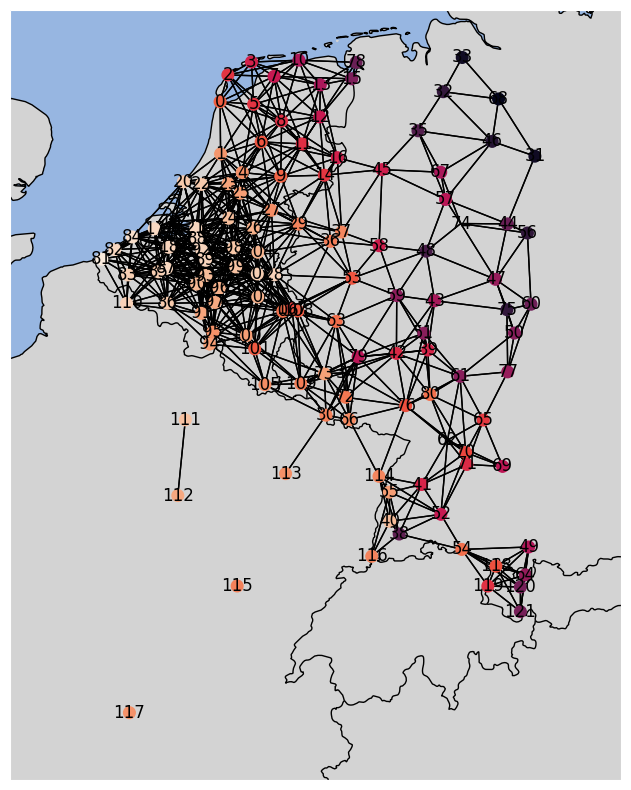

In [15]:
vis = to_networkx(graph1)
plt.figure(1, figsize=(10, 10))
ax = plot_map() # set_extent and fix aspect ratio in this function!
nx.draw_networkx(vis, node_size = 70, node_color = graph1.y.numpy(), pos=pos_dict, arrows=False, ax=ax)
plt.show()

### Graph 2: alt + dist
edges based on dist, num_attr = 2

In [16]:
max_alt = 10 # in welcher einheit (meters above sea level)
alt_dist = compute_mat(dfs["stations"], "altitude")
print(alt_dist)

#alt_mask = get_adj(alt_dist, max_dist=max_alt)
#print(alt_mask.sum())

[[    0.     -4.5     9.6 ...   437.8  1476.8  1585.8]
 [    4.5     0.     14.1 ...   442.3  1481.3  1590.3]
 [   -9.6   -14.1     0.  ...   428.2  1467.2  1576.2]
 ...
 [ -437.8  -442.3  -428.2 ...     0.   1039.   1148. ]
 [-1476.8 -1481.3 -1467.2 ... -1039.      0.    109. ]
 [-1585.8 -1590.3 -1576.2 ... -1148.   -109.      0. ]]


In [17]:
g2_adj = torch.tensor(geo_mask)
geo_d = torch.tensor(geo_dist).unsqueeze(dim = 2)
alt_d = torch.tensor(alt_dist).unsqueeze(dim = 2)
print(alt_d.shape)

std_geo_d = geo_d / geo_d.max()
std_alt_d = alt_d / alt_d.max()

dist_tensor = torch.cat([std_geo_d, std_alt_d], dim=2)
print(dist_tensor.shape)

torch.Size([122, 122, 1])
torch.Size([122, 122, 2])


In [18]:
# create edges
#adj_mat = g2_adj
g2_edges = np.array(np.argwhere(g2_adj))
print(g2_edges.shape)
g2_edge_idx = torch.tensor(g2_edges.T) # torch.Size([1420, 2])

print(f"Edges shape: {g2_edge_idx.shape}")
print(f"Edges: {g2_edge_idx}")
print(f"Total number of edges: {np.sum(g2_adj.numpy())}")

(2, 1420)
Edges shape: torch.Size([1420, 2])
Edges: tensor([[  0,   1],
        [  0,   2],
        [  0,   3],
        ...,
        [121, 118],
        [121, 119],
        [121, 120]])
Total number of edges: 1420


In [19]:
# add attributes
g2_edge_attr = dist_tensor[g2_adj]

print(g2_edge_attr)
print(g2_edge_attr.shape)
print(g2_edge_attr.T[:2, :5])

tensor([[ 7.1109e-02, -2.8279e-03],
        [ 3.7789e-02,  6.0328e-03],
        [ 6.7031e-02, -3.1421e-04],
        ...,
        [ 7.0999e-02, -7.3085e-01],
        [ 5.8104e-02, -7.2142e-01],
        [ 3.3514e-02, -6.8497e-02]], dtype=torch.float64)
torch.Size([1420, 2])
tensor([[ 0.0711,  0.0378,  0.0670,  0.1006,  0.0426],
        [-0.0028,  0.0060, -0.0003,  0.0004, -0.0016]], dtype=torch.float64)


In [20]:
# check sizes:
print(f"{df.station_id.nunique()} nodes and {np.sum(g2_adj.numpy())} edges")
print(f"x: {x.shape}")
print(f"edge_index: {g2_edge_idx.shape}")
print(f"edge_attr: {g2_edge_attr.shape}")
print(f"y: {y.shape}")
print(f"pos: {pos.shape}")

122 nodes and 1420 edges
x: torch.Size([122, 34])
edge_index: torch.Size([1420, 2])
edge_attr: torch.Size([1420, 2])
y: torch.Size([122, 1])
pos: (122, 2)


1420
2
test


<Figure size 1000x1000 with 0 Axes>

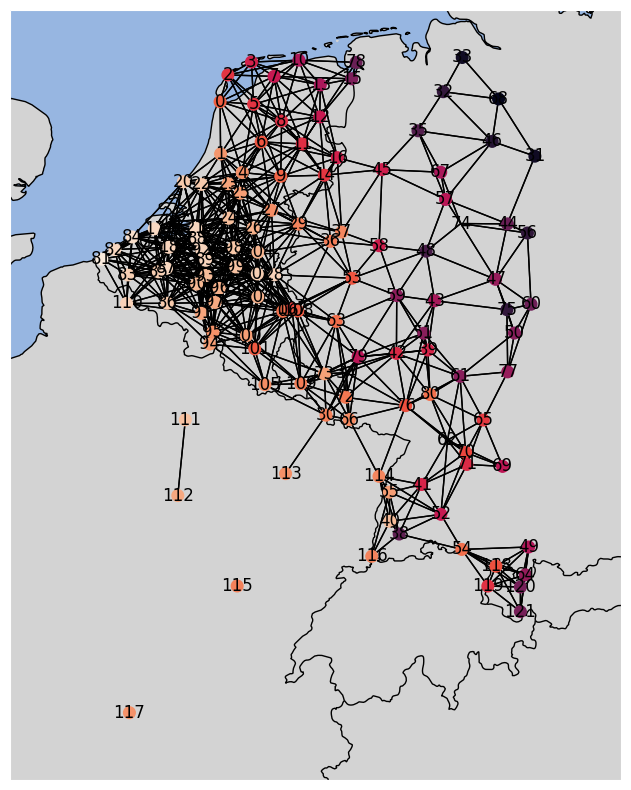

In [21]:
graph2 = Data(x=x, edge_index=g2_edge_idx.T, edge_attr=g2_edge_attr, timestamp=date, y=y)
#graph1
print(graph2.num_edges)
print(graph2.num_edge_features)
vis = to_networkx(graph2)
plt.figure(1, figsize=(10, 10))
ax = plot_map()  # set_extent and fix aspect ratio in this function!
nx.draw_networkx(vis, node_size=70, node_color=graph2.y.numpy(), pos=pos_dict, arrows=False, ax=ax)
plt.show()

### Graph 3: alt + dist
edges based on dist + alt, num_attr = 2

In [28]:
max_geo = 100
geo_dist = compute_mat(dfs['stations'], "geodesic")
print(geo_dist)
geo_mask = get_adj(geo_dist, max_geo)
print(geo_mask.sum())

max_alt = 5 # in welcher einheit (meters above sea level)
alt_dist = compute_mat(dfs["stations"], "altitude")
print(alt_dist)
alt_mask = get_adj(alt_dist, max_dist=max_alt)
print(alt_mask.sum())

[[  0.          67.88302104  36.07414311 ... 717.54863254 739.55923355
  767.55524464]
 [ 67.88302104   0.         103.0930141  ... 659.66900567 683.69191062
  710.83747663]
 [ 36.07414311 103.0930141    0.         ... 743.23584479 763.87800296
  792.39252869]
 ...
 [717.54863254 659.66900567 743.23584479 ...   0.          44.37574719
   55.46816552]
 [739.55923355 683.69191062 763.87800296 ...  44.37574719   0.
   31.99306735]
 [767.55524464 710.83747663 792.39252869 ...  55.46816552  31.99306735
    0.        ]]
1420
[[    0.     -4.5     9.6 ...   437.8  1476.8  1585.8]
 [    4.5     0.     14.1 ...   442.3  1481.3  1590.3]
 [   -9.6   -14.1     0.  ...   428.2  1467.2  1576.2]
 ...
 [ -437.8  -442.3  -428.2 ...     0.   1039.   1148. ]
 [-1476.8 -1481.3 -1467.2 ... -1039.      0.    109. ]
 [-1585.8 -1590.3 -1576.2 ... -1148.   -109.      0. ]]
612


In [29]:
geo_adj = torch.tensor(geo_mask).unsqueeze(dim=2)
alt_adj = torch.tensor(alt_mask).unsqueeze(dim=2)
g3_tensor = torch.cat([geo_adj, alt_adj], dim=2)
g3_adj = g3_tensor.any(dim=2)
print(g3_adj.shape)

geo_d = torch.tensor(geo_dist).unsqueeze(dim=2)
alt_d = torch.tensor(alt_dist).unsqueeze(dim=2)
print(alt_d.shape)

std_geo_d = geo_d / geo_d.max()
std_alt_d = alt_d / alt_d.max()

dist_tensor = torch.cat([std_geo_d, std_alt_d], dim=2)
print(dist_tensor.shape)

torch.Size([122, 122])
torch.Size([122, 122, 1])
torch.Size([122, 122, 2])


In [30]:
# create edges
#adj_mat = g2_adj
g3_edges = np.array(np.argwhere(g3_adj))
print(g3_edges.shape)
g3_edge_idx = torch.tensor(g3_edges.T) # torch.Size([1420, 2])

print(f"Edges shape: {g3_edge_idx.shape}")
print(f"Edges: {g3_edge_idx}")
print(f"Total number of edges: {np.sum(g3_adj.numpy())}")

(2, 1846)
Edges shape: torch.Size([1846, 2])
Edges: tensor([[  0,   1],
        [  0,   2],
        [  0,   3],
        ...,
        [121, 118],
        [121, 119],
        [121, 120]])
Total number of edges: 1846


In [31]:
# add attributes
g3_edge_attr = dist_tensor[g3_adj]

print(g3_edge_attr)
print(g3_edge_attr.shape)
print(g3_edge_attr.T[:2, :5])

tensor([[ 7.1109e-02, -2.8279e-03],
        [ 3.7789e-02,  6.0328e-03],
        [ 6.7031e-02, -3.1421e-04],
        ...,
        [ 7.0999e-02, -7.3085e-01],
        [ 5.8104e-02, -7.2142e-01],
        [ 3.3514e-02, -6.8497e-02]], dtype=torch.float64)
torch.Size([1846, 2])
tensor([[ 0.0711,  0.0378,  0.0670,  0.1006,  0.0426],
        [-0.0028,  0.0060, -0.0003,  0.0004, -0.0016]], dtype=torch.float64)


In [32]:
# check sizes:
print(f"{df.station_id.nunique()} nodes and {np.sum(g3_adj.numpy())} edges")
print(f"x: {x.shape}")
print(f"edge_index: {g3_edge_idx.shape}")
print(f"edge_attr: {g3_edge_attr.shape}")
print(f"y: {y.shape}")
print(f"pos: {pos.shape}")

122 nodes and 1846 edges
x: torch.Size([122, 34])
edge_index: torch.Size([1846, 2])
edge_attr: torch.Size([1846, 2])
y: torch.Size([122, 1])
pos: (122, 2)


1846
2
test


<Figure size 1000x1000 with 0 Axes>

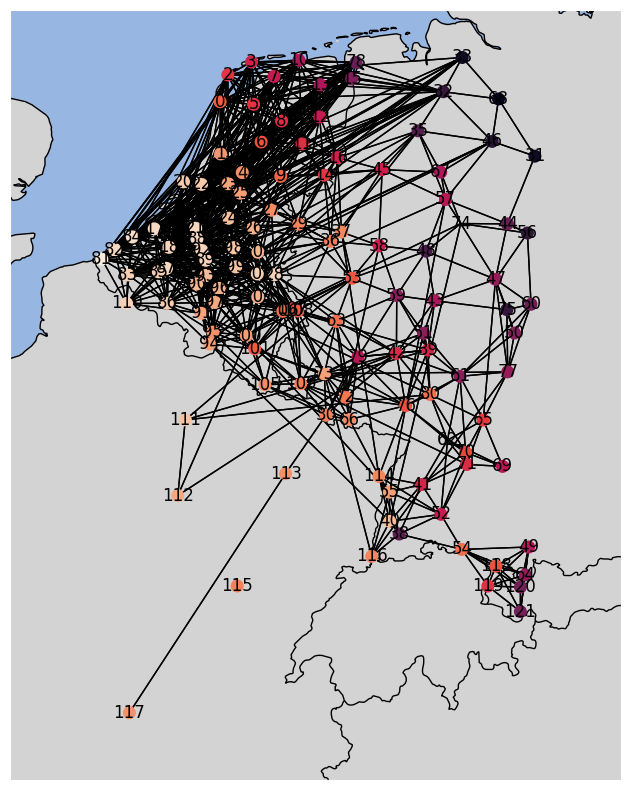

In [33]:
graph3 = Data(x=x, edge_index=g3_edge_idx.T, edge_attr=g3_edge_attr, timestamp=date, y=y)
print(graph3.num_edges)
print(graph3.num_edge_features)
vis = to_networkx(graph3)
plt.figure(1, figsize=(10, 10))
ax = plot_map()  # set_extent and fix aspect ratio in this function!
nx.draw_networkx(vis, node_size=70, node_color=graph3.y.numpy(), pos=pos_dict, arrows=False, ax=ax)
plt.show()

## Alt - Orog

### Graph 1: alt-orog delta

In [ ]:
max_delta = 5
dfs['stations']['alt-orog'] = dfs['stations']['altitude'] - dfs['stations']['']
geo_dist = compute_mat(dfs['stations'], "geodesic")
print(geo_dist)
geo_mask = get_adj(geo_dist, max_geo)
print(geo_mask.sum())
geo_adj = torch.tensor(geo_mask)
geo_d = torch.tensor(geo_dist)
print(geo_d.shape)

In [ ]:
std_geo_d = geo_d / geo_d.max()
# create edges
geo_edges = np.array(np.argwhere(geo_adj))
print(geo_edges.shape)
geo_edge_idx = torch.tensor(geo_edges.T)  # torch.Size([1420, 2])

print(f"Edges shape: {geo_edge_idx.shape}")
print(f"Edges: {geo_edge_idx}")
print(f"Total number of edges: {np.sum(geo_adj.numpy())}")


In [ ]:
# add attributes
geo_edge_attr = std_geo_d[geo_adj]
geo_edge_attr = torch.tensor(geo_edge_attr.reshape(-1, 1))
print(geo_edge_attr)
print(geo_edge_attr.shape)


In [ ]:
# check sizes:
print(f"{df.station_id.nunique()} nodes and {np.sum(geo_adj.numpy())} edges")
print(f"x: {x.shape}")
print(f"edge_index: {geo_edge_idx.shape}")
print(f"edge_attr: {geo_edge_attr.shape}")
print(f"y: {y.shape}")
print(f"pos: {pos.shape}")
graph1 = Data(x=x, edge_index=geo_edge_idx.T, edge_attr=geo_edge_attr, timestamp=date, y=y)


In [ ]:
#graph1
print(graph1.num_edges)
print(graph1.num_edge_features)
vis = to_networkx(graph1)
plt.figure(1, figsize=(10, 10))
ax = plot_map()  # set_extent and fix aspect ratio in this function!
nx.draw_networkx(vis, node_size=70, node_color=graph1.y.numpy(), pos=pos_dict, arrows=False, ax=ax)
plt.show()

### Graph 2: alt-orog-delta + dist

## Use EUPPBench Data
Moritz:
- normalize features and create graphs
- create graphs using create_multigraph

### Data loading

In [2]:
dfs = load_dataframes(mode="train", leadtime="24h")
stations = dfs["stations"]
df_target = dfs['train'][1]
df = dfs['train'][0]

[INFO] Dataframes exist. Will load pandas dataframes.


In [3]:
df_target
df_target[df_target.time == "1997-01-02"].head()
stations.head()

station_id     lat    lon  altitude                  name
0         235  52.928  4.781       1.2               De Kooy
1         240  52.318  4.790      -3.3              Schiphol
2         242  53.241  4.921      10.8              Vlieland
3         251  53.392  5.346       0.7  Hoorn (Terschelling)
4         260  52.100  5.180       1.9               De Bilt

In [5]:
print(f"lon_min: {df['station_longitude'].min()}, lon_max: {df['station_longitude'].max()}")
print(f"lat_min: {df['station_latitude'].min()}, lat_max: {df['station_latitude'].max()}")

print(type(dfs["stations"]))
latlonalt = np.array(dfs["stations"][["lat", "lon", "altitude"]].copy())
print(type(latlonalt))
###

lon_min: 2.652403, lon_max: 10.4464
lat_min: 45.786833, lat_max: 53.4451
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


### Geodesic distance based on Moritz approach
(using Moritz' functions)

In [4]:
# add edges
max_dist = 100
dist = load_distances(dfs["stations"])
mask = get_mask(dist, max_dist=max_dist)  # mask = adjmatrix
print(mask.shape)
edges = np.argwhere(mask)
edge_index = torch.tensor(edges.T)
print(
    edge_index.shape)  # creating real distmatrix necessary? those that are not connected = infinity? => macht keinen Sinn
print(np.sum(mask))
# add edge features
# edge attribute = proximity (shape: (2, num_edges), num_edges = 1420
print(dist[mask])
edge_attr = dist[mask]
print(np.array_equal(dist[edges[:, 0], edges[:, 1]], dist[mask]))
edge_attr = torch.tensor(edge_attr.reshape(-1, 1))
print(edge_attr)
print(edge_attr.shape)  # shape: (num_edges, 1)

# standardization from Moritz:
max_len = np.max(edge_attr.numpy())
print(max_len)
standardized_edge_attr = edge_attr / max_len
print(type(standardized_edge_attr))

mask_1 = mask.astype(int)
print(mask_1)
edge_nonzero = torch.tensor(mask_1).nonzero(as_tuple=False)
print(mask_1)

[INFO] Computing distances...
(122, 122)
torch.Size([2, 1420])
1420
[67.88302104 36.07414311 63.98981385 ... 67.77742374 55.46816552
 31.99306735]
True
tensor([[67.8830],
        [36.0741],
        [63.9898],
        ...,
        [67.7774],
        [55.4682],
        [31.9931]], dtype=torch.float64)
torch.Size([1420, 1])
99.81144527561251
<class 'torch.Tensor'>
[[0 1 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 1 1 0]]
[[0 1 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 1 1 0]]


In [5]:
print(edge_nonzero)

tensor([[  0,   1],
        [  0,   2],
        [  0,   3],
        ...,
        [121, 118],
        [121, 119],
        [121, 120]])


In [6]:
# create data object for one ensemble member (should all be the same)
date = '1997-01-02'
day = df[df.time == date]
ensemble = 0
first_ens = day[day.number == ensemble]
first_ens = first_ens.drop(columns=["time", "number"])
#print(first_ens)
x = torch.tensor(first_ens.to_numpy(dtype=np.float32))
target = df_target[df_target.time == date]
target = target.drop(columns=["time", "station_id"]).to_numpy()
y = torch.tensor(target)
print(type(target))
lon = first_ens["station_longitude"].to_numpy().reshape(-1, 1)
print(lon.shape)
lat = first_ens["station_latitude"].to_numpy().reshape(-1, 1)
print(lat.shape)
pos = torch.tensor(np.concatenate([lon, lat], axis=1))

# Moritz has a conversion to celsius here, but should do it elsewhere (preprocess?)

# check sizes:
print(f"{df.station_id.nunique()} nodes and {np.sum(mask)} edges")
print(f"x: {x.shape}")
print(f"edge_index: {edge_index.shape}")
print(f"edge_attr: {edge_attr.shape}")
print(f"y: {y.shape}")
print(f"pos: {pos.shape}")

<class 'numpy.ndarray'>
(122, 1)
(122, 1)
122 nodes and 1420 edges
x: torch.Size([122, 34])
edge_index: torch.Size([2, 1420])
edge_attr: torch.Size([1420, 1])
y: torch.Size([122, 1])
pos: torch.Size([122, 2])


In [7]:
graph3 = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, timestamp=date, y=y)
graph3
positions3 = pos.numpy().reshape(-1, 2)
positions3
print(graph3.num_edges)

1420


<Figure size 1000x1000 with 0 Axes>

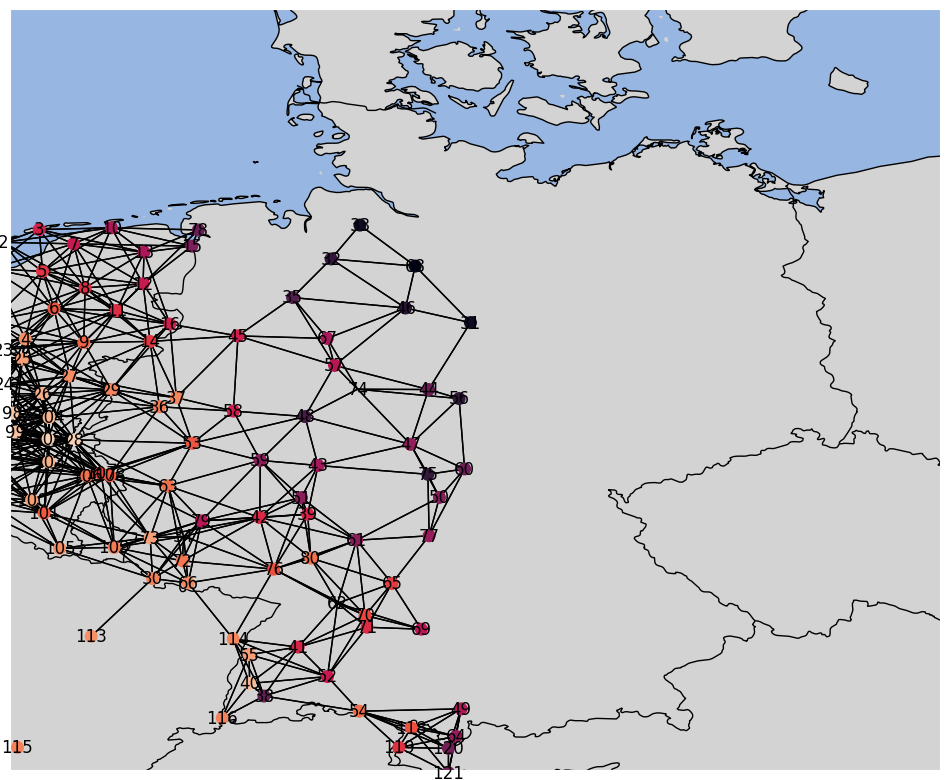

In [8]:
pos_dict = dict(enumerate(positions3))
vis = to_networkx(graph3)
plt.figure(1, figsize=(10, 10))
ax = plot_map() # set_extent and fix aspect ratio in this function!
nx.draw_networkx(vis, node_size = 70, node_color = graph3.y.numpy(), pos=pos_dict, arrows=False, ax=ax)
plt.show()


### 4 Attributes added to graph
- geodesic distance
- longitude
- latitude
- altitude

In [ ]:
# Changes
# add celsius umrechnung, standardization (added)
# how should ensemble graphs be connected with each other?

In [27]:
# compute distance matrix for geo, lon, lat, alt
max_geo = 50
geo_dist = compute_mat(dfs['stations'], "geodesic")
print(geo_dist)
geo_mask = get_adj(geo_dist, max_geo)
print(geo_mask.sum())

max_lon = 20
lon_dist = compute_mat(dfs["stations"], "lon")
print(lon_dist)
lon_mask = get_adj(lon_dist, max_dist=max_lon)  # mask = adjmatrix
print(lon_mask.sum())

max_lat = 20
lat_dist = compute_mat(dfs["stations"], "lat")
print(lat_dist)
lat_mask = get_adj(lat_dist, max_dist=max_lat)  # mask = adjmatrix
print(lat_mask.sum())

max_alt = 10 # in welcher einheit
alt_dist = compute_mat(dfs["stations"], "altitude")
print(alt_dist)
alt_mask = get_adj(alt_dist, max_dist=max_alt)
print(alt_mask.sum())

[[  0.          67.88302104  36.07414311 ... 717.54863254 739.55923355
  767.55524464]
 [ 67.88302104   0.         103.0930141  ... 659.66900567 683.69191062
  710.83747663]
 [ 36.07414311 103.0930141    0.         ... 743.23584479 763.87800296
  792.39252869]
 ...
 [717.54863254 659.66900567 743.23584479 ...   0.          44.37574719
   55.46816552]
 [739.55923355 683.69191062 763.87800296 ...  44.37574719   0.
   31.99306735]
 [767.55524464 710.83747663 792.39252869 ...  55.46816552  31.99306735
    0.        ]]
348
[[0.00000000e+00 1.00187542e+00 1.55847287e+01 ... 5.36448626e+02
  6.01694204e+02 6.01632311e+02]
 [1.00187542e+00 0.00000000e+00 1.45828533e+01 ... 5.35446751e+02
  6.00692329e+02 6.00630435e+02]
 [1.55847287e+01 1.45828533e+01 0.00000000e+00 ... 5.20863897e+02
  5.86109475e+02 5.86047582e+02]
 ...
 [5.36448626e+02 5.35446751e+02 5.20863897e+02 ... 0.00000000e+00
  6.52455781e+01 6.51836844e+01]
 [6.01694204e+02 6.00692329e+02 5.86109475e+02 ... 6.52455781e+01
  0.00000

In [14]:
# concatenate => distance tensor, adjacency tensor with lon, lat
geo_adj = torch.tensor(geo_mask).unsqueeze(dim=2)
lon_adj = torch.tensor(lon_mask).unsqueeze(dim = 2)
lat_adj = torch.tensor(lat_mask).unsqueeze(dim = 2)
alt_adj = torch.tensor(alt_mask).unsqueeze(dim=2)
adj_tensor = torch.cat([geo_adj, lon_adj, lat_adj, alt_adj], dim=2)
#adj_tensor = torch.cat([lon_adj, lat_adj], dim=2)
print(lon_adj.shape)
print(lat_adj.shape)
print(adj_tensor.shape)

geo_d = torch.tensor(geo_dist).unsqueeze(dim = 2)
lon_d = torch.tensor(lon_dist).unsqueeze(dim = 2)
lat_d = torch.tensor(lat_dist).unsqueeze(dim = 2)
alt_d = torch.tensor(alt_dist).unsqueeze(dim = 2)
dist_tensor = torch.cat([geo_d, lon_d, lat_d, alt_d], dim=2)
#dist_tensor = torch.cat([lon_d, lat_d], dim=2)
print(geo_d.shape)
print(lon_d.shape)
print(lat_d.shape)
print(dist_tensor.shape)
print(dist_tensor.max())
print(alt_mask.sum()+lat_mask.sum()+lon_mask.sum()+geo_mask.sum())
#print(lat_mask.sum()+lon_mask.sum())
print(adj_tensor.shape[2])

torch.Size([122, 122, 1])
torch.Size([122, 122, 1])
torch.Size([122, 122, 4])
torch.Size([122, 122, 1])
torch.Size([122, 122, 1])
torch.Size([122, 122, 1])
torch.Size([122, 122, 4])
tensor(1591.3000, dtype=torch.float64)
2934
4


In [15]:
# create edges
# adj_tensor: more dimensions (122, 122, num_edge_feat)
# adj_mat: two dimensions of shape (122, 122)
adj_mat = adj_tensor.any(dim=2)
print(adj_mat.shape)
# alt_edges: (2, num_edges)
all_edges = np.array(np.argwhere(adj_mat))
print(all_edges.shape)
all_edge_index = torch.tensor(all_edges.T)
print(f"lon and lat edges shape: {all_edge_index.shape}")
print(f"lon and lat edges: {all_edge_index}")
# remove self loops
print(f"total number of edges: {np.sum(adj_mat.numpy())}")

torch.Size([122, 122])
(2, 2460)
lon and lat edges shape: torch.Size([2460, 2])
lon and lat edges: tensor([[  0,   1],
        [  0,   2],
        [  0,   3],
        ...,
        [121,  56],
        [121,  64],
        [121, 120]])
total number of edges: 2460


In [25]:
# create edge features from adj_tensor for 4 attributes
# edge attribute = proximity (shape: (2, num_edges), num_edges = 1420)
# 4 edge attributes ((shape: (2, num_edges), num_edges = 2460)
num_attr = adj_tensor.shape[2]
num_edges = np.sum(adj_mat.numpy())
all_edge_attr = np.zeros((num_attr, num_edges))
print(all_edge_attr.shape)
print(adj_mat)
for index, e in enumerate(all_edge_index):
    e = np.array(e)
    print(f"e[0]: {e[0]} e[1]: {e[1]}") # wenn die Kante existiert, dann alle Informationen
    print(index)
    #print(adj_mat[e[0]][e[1]]) # are all True because all edges in all_edge_index should be True
    #print(dist_tensor[e[0]][e[1]].shape)
    #print(all_edge_attr[:,index].shape)
    all_edge_attr[:,index] = dist_tensor[e[0]][e[1]]

#    # geo
#    if adj_tensor[e[0]][e[1]][0] == True:
#        all_edge_attr[0][index] = dist_tensor[e[0]][e[1]][0]
#        #print(all_edge_attr[0][index])
#    # lon
#    if adj_tensor[e[0]][e[1]][1] == True:
#        all_edge_attr[1][index] = dist_tensor[e[0]][e[1]][1]
#        #print(all_edge_attr[1][index])
#    # lat
#    if adj_tensor[e[0]][e[1]][2] == True:
#        all_edge_attr[2][index] = dist_tensor[e[0]][e[1]][2]
#        #print(all_edge_attr[1][index])
#    # alt
#    if adj_tensor[e[0]][e[1]][3] == True:
#        all_edge_attr[3][index] = dist_tensor[e[0]][e[1]][3]
#        #print(all_edge_attr[1][index])

print(all_edge_attr)
print(all_edge_attr.shape)

(4, 2460)
tensor([[False,  True,  True,  ..., False, False, False],
        [ True, False,  True,  ..., False, False, False],
        [ True,  True, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False,  True, False],
        [False, False, False,  ...,  True, False,  True],
        [False, False, False,  ..., False,  True, False]])
e[0]: 0 e[1]: 1
0
e[0]: 0 e[1]: 2
1
e[0]: 0 e[1]: 3
2
e[0]: 0 e[1]: 4
3
e[0]: 0 e[1]: 5
4
e[0]: 0 e[1]: 6
5
e[0]: 0 e[1]: 7
6
e[0]: 0 e[1]: 8
7
e[0]: 0 e[1]: 10
8
e[0]: 0 e[1]: 11
9
e[0]: 0 e[1]: 12
10
e[0]: 0 e[1]: 13
11
e[0]: 0 e[1]: 15
12
e[0]: 0 e[1]: 17
13
e[0]: 0 e[1]: 18
14
e[0]: 0 e[1]: 19
15
e[0]: 0 e[1]: 22
16
e[0]: 0 e[1]: 23
17
e[0]: 0 e[1]: 24
18
e[0]: 0 e[1]: 25
19
e[0]: 0 e[1]: 32
20
e[0]: 0 e[1]: 33
21
e[0]: 0 e[1]: 68
22
e[0]: 0 e[1]: 78
23
e[0]: 0 e[1]: 81
24
e[0]: 0 e[1]: 82
25
e[0]: 0 e[1]: 88
26
e[0]: 0 e[1]: 89
27
e[0]: 0 e[1]: 95
28
e[0]: 0 e[1]: 96
29
e[0]: 0 e[1]: 97
30
e[0]: 1 e[1]: 0
31
e[0]: 1

In [26]:
print(all_edge_attr[:4, :5])
#print(ll_edge_attr[ll_edge_attr < 0]) # nur altitudes
# check edge no. 6
i = 1
print(dist_tensor[all_edge_index[i][0]][all_edge_index[i][1]])
print(all_edge_index[i])


[[67.88302104 36.07414311 63.98981385 96.03626077 40.70210664]
 [ 1.00187542 15.58472871 62.8955123  44.41647683 67.12565295]
 [67.88028503 34.83309997 51.63822512 92.1374329   3.33853893]
 [-4.5         9.6        -0.5         0.7        -2.5       ]]
tensor([36.0741, 15.5847, 34.8331,  9.6000], dtype=torch.float64)
tensor([0, 2])


In [11]:
# for lon lat edges:
# create data object for one ensemble member (should all be the same)
date = '1997-01-02'
day = df[df.time == date]
ensemble = 0
first_ens = day[day.number == ensemble]
first_ens = first_ens.drop(columns=["time", "number"])
#print(first_ens)
x = torch.tensor(first_ens.to_numpy(dtype=np.float32))
target = df_target[df_target.time == date]
target = target.drop(columns=["time", "station_id"]).to_numpy()
y = torch.tensor(target)
print(type(target))
lon = first_ens["station_longitude"].to_numpy().reshape(-1, 1)
print(lon.shape)
lat = first_ens["station_latitude"].to_numpy().reshape(-1, 1)
print(lat.shape)
pos = torch.tensor(np.concatenate([lon, lat], axis=1))

# Moritz has a conversion to celsius here, but should do it elsewhere (preprocess?)

# check sizes:
print(f"{df.station_id.nunique()} nodes and {torch.sum(adj_mat)} edges")
print(f"x: {x.shape}")
print(f"all_edge_index: {all_edge_index.T.shape}")
print(f"all_edge_attr: {all_edge_attr.T.shape}")
print(f"y: {y.shape}")
print(f"pos: {pos.shape}")

<class 'numpy.ndarray'>
(122, 1)
(122, 1)
122 nodes and 2460 edges
x: torch.Size([122, 34])
all_edge_index: torch.Size([2, 2460])
all_edge_attr: (2460, 4)
y: torch.Size([122, 1])
pos: torch.Size([122, 2])


#### Create a graph
Pytorch data object
- .x (num_nodes, num_node_feats)
- .edge_index (2, num_edges)
- .edge_attr (num_edges, num_edge_feats)
- .y (num_nodes, *)
- .pos (num_nodes, node_dim)

In [12]:
#graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, timestamp=date, y=y, pos=pos)
graph = Data(x=x, edge_index=all_edge_index.T, edge_attr=all_edge_attr.T, timestamp=date, y=y)
graph
positions = pos.numpy().reshape(-1, 2)
positions
print(graph.num_edges)

2460


test


<Figure size 1000x1000 with 0 Axes>

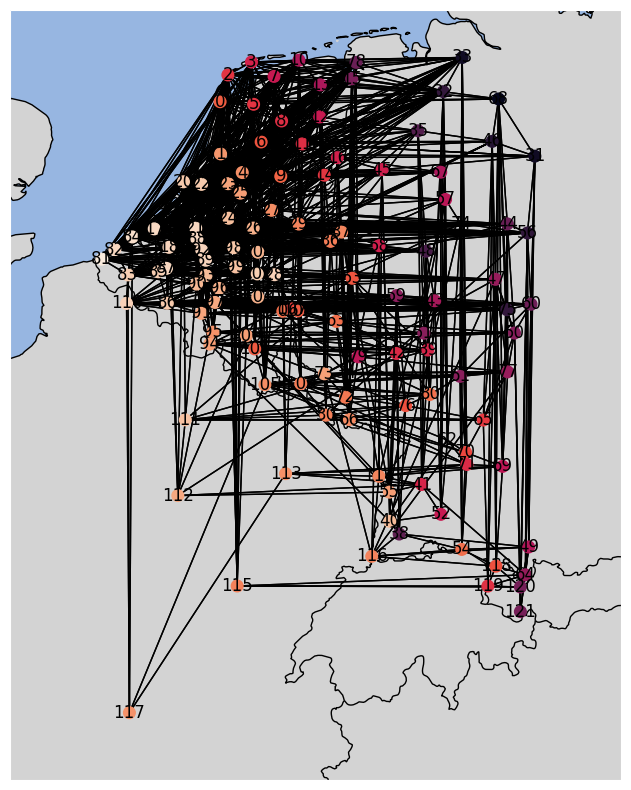

In [19]:
pos_dict = dict(enumerate(positions))
vis = to_networkx(graph)
plt.figure(1, figsize=(10, 10))
#ax = plot_map()
###

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.coastlines()
ax.set_extent([1, 12, 45, 54], crs=proj)
ax.add_feature(cfeature.LAND, color="lightgrey")
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.OCEAN)

# Fix the aspect ratio of the map
lat_center = (ax.get_extent()[2] + ax.get_extent()[3]) / 2
ax.set_aspect(1 / np.cos(np.radians(lat_center)))
print("test")

###
nx.draw_networkx(vis, node_size = 70, node_color = graph.y.numpy(), pos=pos_dict, arrows=False, ax = ax)
plt.show()

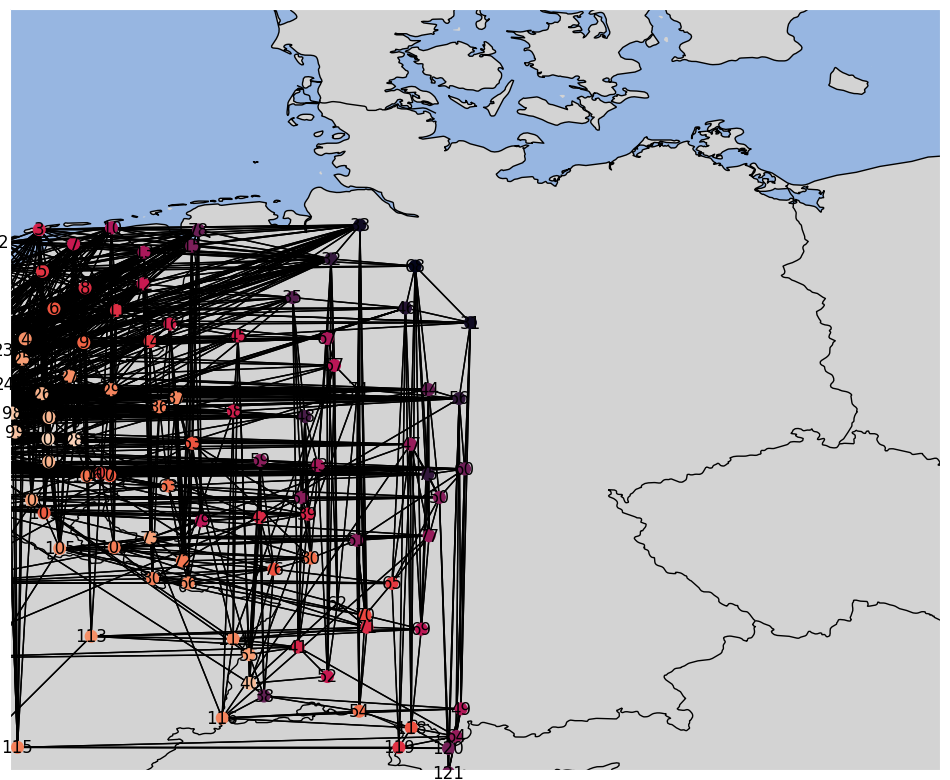

In [14]:
ax = plot_map() # set_extent and fix aspect ratio in this function!
nx.draw_networkx(vis, node_size = 70, node_color = graph.y.numpy(), pos=pos_dict, arrows=False, ax=ax)
plt.show()

### Only lon lat

In [252]:
# unchanged from all 4 attributes
def signed_difference(x, y): # macht es Sinn signed difference zu benutzen?
    return x - y

def dist_km(lat1: float = 0, lon1: float = 0, lat2: float = 0, lon2: float = 0) -> float:
    return geopy.distance.geodesic((lat1, lon1), (lat2, lon2)).km # macht es Sinn, das Vorzeichen durch geodesic wegzulassen?
# not use signed difference for lon / lat but rather geodesic

def compute_mat(df: pd.DataFrame, mode: str) -> np.array:
    if mode == "lon":
        lon = np.array(df["lon"].copy())
        mesh1, mesh2 = np.meshgrid(lon, lon)
        distance_matrix = np.vectorize(dist_km)(lon1 =mesh1, lon2=mesh2)
    if mode == "lat":
        lat = np.array(df["lat"].copy())
        mesh1, mesh2 = np.meshgrid(lat, lat) # check if this meshgrid actually works!!
        distance_matrix = np.vectorize(dist_km)(lat1=mesh1, lat2=mesh2)
    return distance_matrix

def get_adj(dist_matrix_sliced: np.array, max_dist: float = 50) -> np.array:
    mask = None
    mask = (dist_matrix_sliced <= max_dist) & (dist_matrix_sliced >= (-max_dist)) # brauche fuer lon oder laat kein >= negativ, da alle positiv sind durch geodesic, nur altitude braucht das
    diagonal = np.full((mask.shape[0], mask.shape[1]), True, dtype=bool)
    np.fill_diagonal(diagonal, False)
    mask = np.logical_and(mask, diagonal)
    return mask

In [253]:
max_lon = 20
lon_dist = compute_mat(dfs["stations"], "lon")
print(lon_dist)
lon_mask = get_adj(lon_dist, max_dist=max_lon)  # mask = adjmatrix
print(lon_mask.sum())

max_lat = 20
lat_dist = compute_mat(dfs["stations"], "lat")
#print(lat_dist)
lat_mask = get_adj(lat_dist, max_dist=max_lat)  # mask = adjmatrix
print(lat_mask.sum())

[[0.00000000e+00 1.00187542e+00 1.55847287e+01 ... 5.36448626e+02
  6.01694204e+02 6.01632311e+02]
 [1.00187542e+00 0.00000000e+00 1.45828533e+01 ... 5.35446751e+02
  6.00692329e+02 6.00630435e+02]
 [1.55847287e+01 1.45828533e+01 0.00000000e+00 ... 5.20863897e+02
  5.86109475e+02 5.86047582e+02]
 ...
 [5.36448626e+02 5.35446751e+02 5.20863897e+02 ... 0.00000000e+00
  6.52455781e+01 6.51836844e+01]
 [6.01694204e+02 6.00692329e+02 5.86109475e+02 ... 6.52455781e+01
  0.00000000e+00 6.18936369e-02]
 [6.01632311e+02 6.00630435e+02 5.86047582e+02 ... 6.51836844e+01
  6.18936369e-02 0.00000000e+00]]
652
898


In [259]:
lon_adj = torch.tensor(lon_mask).unsqueeze(dim = 2)
lat_adj = torch.tensor(lat_mask).unsqueeze(dim = 2)
adj_tensor = torch.cat([lon_adj, lat_adj], dim=2)
print(lon_adj.shape)
print(lat_adj.shape)
print(adj_tensor.shape)

lon_d = torch.tensor(lon_dist).unsqueeze(dim = 2)
lat_d = torch.tensor(lat_dist).unsqueeze(dim = 2)
dist_tensor = torch.cat([lon_d, lat_d], dim=2)
print(lon_d.shape)
print(lat_d.shape)
print(dist_tensor.shape)
print(dist_tensor.max())
print(lat_mask.sum()+lon_mask.sum())

torch.Size([122, 122, 1])
torch.Size([122, 122, 1])
torch.Size([122, 122, 2])
torch.Size([122, 122, 1])
torch.Size([122, 122, 1])
torch.Size([122, 122, 2])
tensor(867.6238, dtype=torch.float64)
1550


In [260]:
adj_mat = adj_tensor.any(dim=2)
print(adj_mat.shape)
# alt_edges: (2, num_edges)
lonlat_edges = np.array(np.argwhere(adj_mat))
print(lonlat_edges.shape)
lonlat_edge_index = torch.tensor(lonlat_edges.T)
print(f"lon and lat edges shape: {lonlat_edge_index.shape}")
print(f"lon and lat edges: {lonlat_edge_index}")
# remove self loops
print(f"total number of edges: {np.sum(adj_mat.numpy())}")
# create edge features from adj_tensor for 4 attributes
# edge attribute = proximity (shape: (2, num_edges), num_edges = 1420)
# 4 edge attributes ((shape: (2, num_edges), num_edges = 2460)
num_attr = adj_tensor.shape[2]
num_edges = np.sum(adj_mat.numpy())
lonlat_edge_attr = np.zeros((num_attr, num_edges))
print(lonlat_edge_attr.shape)
for index, e in enumerate(lonlat_edge_index):
    e = np.array(e)
    #print(f"e[0]: {e[0]} e[1]: {e[1]}")
    #print(index)
    # lon
    if adj_tensor[e[0]][e[1]][0] == True:
        lonlat_edge_attr[0][index] = dist_tensor[e[0]][e[1]][0]
        #print(lonlat_edge_attr[0][index])
    # lat
    if adj_tensor[e[0]][e[1]][1] == True:
        lonlat_edge_attr[1][index] = dist_tensor[e[0]][e[1]][1]
        #print(lonlat_edge_attr[1][index])
print(lonlat_edge_attr)

torch.Size([122, 122])
(2, 1522)
lon and lat edges shape: torch.Size([1522, 2])
lon and lat edges: tensor([[  0,   1],
        [  0,   2],
        [  0,   5],
        ...,
        [121,  56],
        [121,  64],
        [121, 120]])
total number of edges: 1522
(2, 1522)
[[ 1.00187542 15.58472871  0.         ... 14.10918886 10.0571594
   0.06189364]
 [ 0.          0.          3.33853893 ...  0.          0.
   0.        ]]


In [261]:
print(lonlat_edge_attr[:4, :5])
#print(lonlat_edge_attr[lonlat_edge_attr < 0]) # nur altitudes
# check edge no. 6
i = 1
print(dist_tensor[lonlat_edge_index[i][0]][lonlat_edge_index[i][1]])
print(lonlat_edge_index[i])

[[ 1.00187542 15.58472871  0.          0.         16.14132617]
 [ 0.          0.          3.33853893 19.80841596  0.        ]]
tensor([15.5847, 34.8331], dtype=torch.float64)
tensor([0, 2])


In [262]:
# for lon lat edges:
# create data object for one ensemble member (should all be the same)
date = '1997-01-02'
day = df[df.time == date]
ensemble = 0
first_ens = day[day.number == ensemble]
first_ens = first_ens.drop(columns=["time", "number"])
#print(first_ens)
x = torch.tensor(first_ens.to_numpy(dtype=np.float32))
target = df_target[df_target.time == date]
target = target.drop(columns=["time", "station_id"]).to_numpy()
y = torch.tensor(target)
print(type(target))
lon = first_ens["station_longitude"].to_numpy().reshape(-1, 1)
print(lon.shape)
lat = first_ens["station_latitude"].to_numpy().reshape(-1, 1)
print(lat.shape)
pos = torch.tensor(np.concatenate([lon, lat], axis=1))

# Moritz has a conversion to celsius here, but should do it elsewhere (preprocess?)

# check sizes:
print(f"{df.station_id.nunique()} nodes and {torch.sum(adj_mat)} edges")
print(f"x: {x.shape}")
print(f"lonlat_edge_index: {lonlat_edge_index.T.shape}")
print(f"lonlat_edge_attr: {lonlat_edge_attr.T.shape}")
print(f"edge_index: {edge_index.shape}")
print(f"edge_attr: {edge_attr.shape}")
print(f"y: {y.shape}")
print(f"pos: {pos.shape}")

<class 'numpy.ndarray'>
(122, 1)
(122, 1)
122 nodes and 1522 edges
x: torch.Size([122, 34])
lonlat_edge_index: torch.Size([2, 1522])
lonlat_edge_attr: (1522, 2)
edge_index: torch.Size([2, 1420])
edge_attr: torch.Size([1420, 1])
y: torch.Size([122, 1])
pos: torch.Size([122, 2])


2460


<Figure size 1000x1000 with 0 Axes>

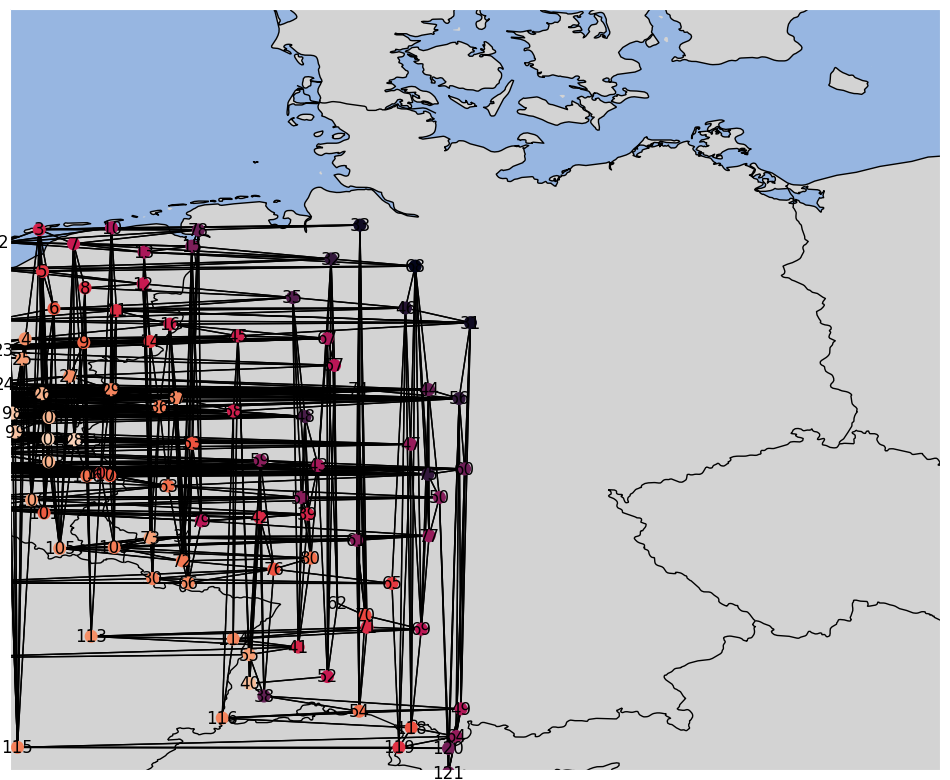

In [263]:
#graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, timestamp=date, y=y, pos=pos)
graph4 = Data(x=x, edge_index=lonlat_edge_index.T, edge_attr=lonlat_edge_attr.T, timestamp=date, y=y)
graph4
positions4 = pos.numpy().reshape(-1, 2)
positions4
print(graph.num_edges)
pos_dict = dict(enumerate(positions4))
vis = to_networkx(graph4)
plt.figure(1, figsize=(10, 10))
ax = plot_map()  # set_extent and fix aspect ratio in this function!
nx.draw_networkx(vis, node_size=70, node_color=graph4.y.numpy(), pos=pos_dict, arrows=False, ax=ax)
plt.show()

### Only altitude

In [16]:
# add edges for altitude => how is distance calculated? => calculate altitude differences!
def signed_difference(x, y):
    return x - y

def compute_alt_mat(df: pd.DataFrame) -> np.array:
    altitudes = np.array(df["altitude"].copy())
    # create a meshgrid of altitudes
    alt_mesh1, alt_mesh2 = np.meshgrid(altitudes, altitudes)
    # calculate distance matrix using vectorized distance function
    distance_matrix = np.vectorize(signed_difference)(alt_mesh1, alt_mesh2)
    return distance_matrix

def get_alt_mask(dist_matrix_sliced: np.array, max_dist: int = 50) -> np.array:
    mask = None
    mask = (dist_matrix_sliced <= max_dist) & (dist_matrix_sliced >= (-max_dist))
    diagonal = np.full((mask.shape[0], mask.shape[1]), True, dtype=bool)
    np.fill_diagonal(diagonal, False)
    mask = np.logical_and(mask, diagonal)
    return mask

max_alt_dist = 50
alt_dist = compute_alt_mat(dfs["stations"])
alt_mask = get_alt_mask(alt_dist, max_dist=max_alt_dist)  # mask = adjmatrix
#print(alt_mask.shape)
alt_edges = np.argwhere(alt_mask)
alt_edge_index = torch.tensor(alt_edges.T)
print(f"altitude edges shape: {alt_edge_index.shape}")  # creating real distmatrix necessary? those that are not connected = infinity? => macht keinen Sinn
print(f"altitude edges: {alt_edge_index}")
# remove self loops
print(f"total number of edges: {np.sum(alt_mask)}")

# add edge features
# edge attribute = proximity (shape: (2, num_edges), num_edges = 1420
alt_edge_attr = alt_dist[alt_mask]
# print(np.array_equal(alt_dist[alt_edges[:, 0], alt_edges[:, 1]], alt_dist[alt_mask]))
alt_edge_attr = torch.tensor(alt_edge_attr.reshape(-1, 1))
print(alt_edge_attr)
print(alt_edge_attr.shape)  # shape: (num_edges, 1)
# alt_dist
#compute_alt_mat(stations)
# should I add edges between those that are close to each other by altitude
# additional edge attribute = altitude

altitude edges shape: torch.Size([2, 3166])
altitude edges: tensor([[  0,   0,   0,  ..., 119, 119, 120],
        [  1,   2,   3,  ..., 106, 118,  38]])
total number of edges: 3166
tensor([[ -4.5000],
        [  9.6000],
        [ -0.5000],
        ...,
        [ 43.0000],
        [-15.0000],
        [ 11.6000]], dtype=torch.float64)
torch.Size([3166, 1])


In [17]:
# Moritz has a conversion to celsius here, but should do it elsewhere (preprocess?)
total_edge_index = torch.tensor(np.concatenate([edge_index, alt_edge_index], axis=1)) # unterscheidest nicht zwischen den edge attributes gerade
first_edge_attr = np.concatenate([edge_attr, np.zeros((alt_edge_attr.shape[0], 1))], axis=0)
print(first_edge_attr.shape)
#print(edge_attr.numpy().shape[0])
print(alt_edge_attr.numpy())
one = (edge_attr.numpy().shape[0], 1)
print(one)
two = alt_edge_attr
print(two.numpy())
second_edge_attr = np.concatenate([np.zeros(one), two], axis=0)
print(second_edge_attr)
total_edge_attr = torch.tensor(np.concatenate([first_edge_attr, second_edge_attr], axis=1))
print(total_edge_attr)

# check sizes:
print(f"{df.station_id.nunique()} nodes and {np.sum(mask)} edges")
print(f"x: {x.shape}")
print(f"edge_index: {total_edge_index.shape}")
print(f"edge_attr: {total_edge_attr.shape}")
print(f"y: {y.shape}")
print(f"pos: {pos.shape}")
# adj als tensor (node, node, attr)
# keine edges doppelt!
# ost-west und nord-sued distanzen

(4586, 1)
[[ -4.5]
 [  9.6]
 [ -0.5]
 ...
 [ 43. ]
 [-15. ]
 [ 11.6]]
(1420, 1)
[[ -4.5]
 [  9.6]
 [ -0.5]
 ...
 [ 43. ]
 [-15. ]
 [ 11.6]]
[[  0. ]
 [  0. ]
 [  0. ]
 ...
 [ 43. ]
 [-15. ]
 [ 11.6]]
tensor([[ 67.8830,   0.0000],
        [ 36.0741,   0.0000],
        [ 63.9898,   0.0000],
        ...,
        [  0.0000,  43.0000],
        [  0.0000, -15.0000],
        [  0.0000,  11.6000]], dtype=torch.float64)
122 nodes and 1420 edges
x: torch.Size([122, 34])
edge_index: torch.Size([2, 4586])
edge_attr: torch.Size([4586, 2])
y: torch.Size([122, 1])
pos: torch.Size([122, 2])


In [18]:
graph2 = Data(x=x, edge_index=total_edge_index, edge_attr=total_edge_attr, timestamp=date, y=y, pos=pos)
graph2

Data(x=[122, 34], edge_index=[2, 4586], edge_attr=[4586, 2], y=[122, 1], pos=[122, 2], timestamp='1997-01-02')

<Figure size 1000x1000 with 0 Axes>

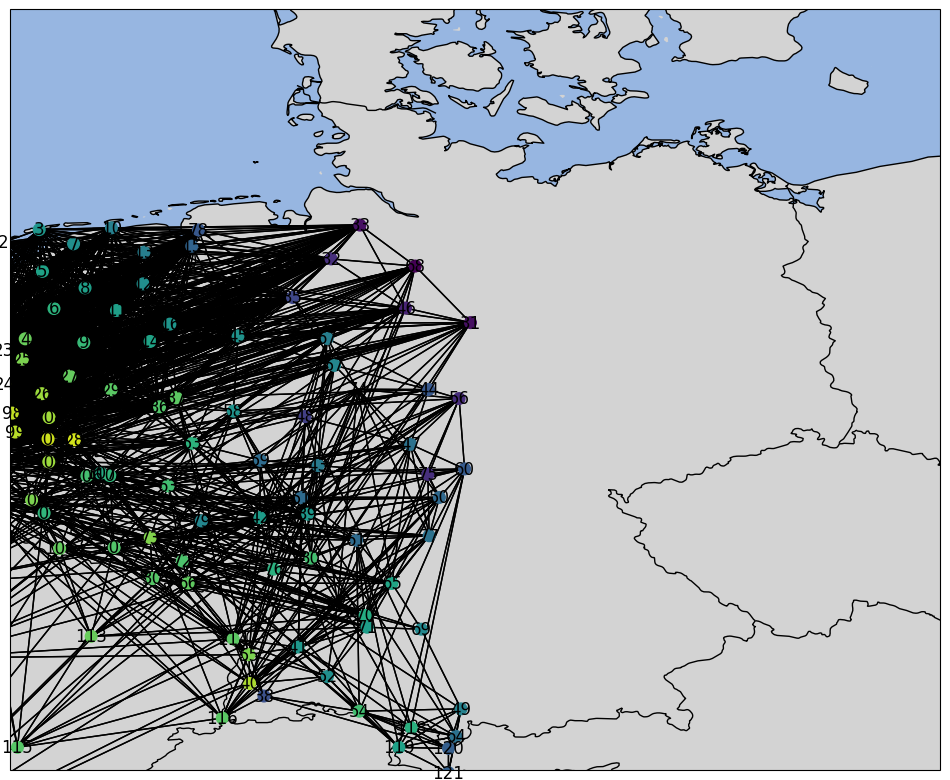

In [19]:
pos_dict = dict(enumerate(graph2.pos.numpy().reshape(-1, 2)))
vis2 = to_networkx(graph2)
plt.figure(1, figsize=(10, 10))
ax = plot_map()  # set_extent and fix aspect ratio in this function!
nx.draw_networkx(vis2, node_size=70, node_color=graph2.y.numpy(), pos=pos_dict, arrows=False, ax=ax)
plt.show()

## All ensemble members for one attribute

In [22]:
# for-loop for all ensemble members => nur Unterschiede in features: x
n_fc = len(df.number.unique())
n_nodes = len(df.station_id.unique())
full_edge_attr = np.repeat(standardized_edge_attr, n_fc, axis=1).T.reshape(-1, 1)
full_edge_attr.shape

torch.Size([15620, 1])

In [37]:
edge_index
# ein knoten
# a) summary statistics
# attributsdimension erhoehen

tensor([[  0,   0,   0,  ..., 121, 121, 121],
        [  1,   2,   3,  ..., 118, 119, 120]])

In [93]:
values_to_add = np.arange(n_fc) * (n_nodes) # [   0  122  244  366  488  610  732  854  976 1098 1220]
print(values_to_add.shape)
stacked = np.repeat(edge_index[np.newaxis, ...], n_fc, axis=0) + values_to_add[:, np.newaxis, np.newaxis]
# edge_index[np.newaxis, ...].shape = [1, 2, 1420] repeated n_fc times
# shape: [11, 2, 1420] + [11, 1, 1] = [11, 2, 1420]
full_edge_index = np.transpose(stacked, (1, 0, 2)).reshape(2, -1) # shape: [2, 11, 1420].reshape() => [2, 15620]
print(full_edge_index.shape)

(11,)
torch.Size([2, 15620])


In [94]:
n_layers = n_fc # 11
# n_nodes = 122
all_layers = []
start_i = 0
start_j = n_nodes
for i in range(n_layers):
    layer_i = np.arange(start_i, start_i + n_nodes) # i=0: [0, 1, 2, ... 121], i=1: [122, 123, 124, ... 243]
    start_j = start_i + n_nodes # i=0: 122, i=1: 244
    for j in range(i + 1, n_layers): # range(1, 11)
        layer_array = np.empty((2, n_nodes), dtype=int)
        layer_array[0] = layer_i
        layer_array[1] = np.arange(start_j, start_j + n_nodes) # [122, 123, 124, ... 243]
        all_layers.append(layer_array)
        start_j += n_nodes
    start_i += n_nodes
    print(all_layers)
connections = np.hstack(all_layers)
connections_bidirectional = np.hstack([connections, np.flip(connections, axis=0)])
# n_fc mal wiederholen der ersten layer i=0: [0, 121] => station_id
# zweite layer zaehlt durch ab 122 bis 1341
# connections zwischen den nodes mit allen moeglichen namen
connections_bidirectional.shape

[array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121],
       [122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
        135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
        148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
        161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
        174, 175

(2, 13420)

In [95]:
print(np.hstack([edge_index, generate_layers(n_nodes, n_layers=n_fc)]).shape)
generate_layers(n_nodes, n_layers=n_fc) #[2, 13420]
print(generate_layers(n_nodes, n_layers=n_fc).shape)

(2, 14840)
(2, 13420)


In [99]:
# add connections between layers
print(full_edge_index.shape) # ([2, 15620])
print(generate_layers(n_nodes, n_layers=n_fc).shape)
if n_fc > 1:
    full_edge_index = np.hstack([full_edge_index, generate_layers(n_nodes, n_layers=n_fc)]) # [2, 11420] and [2, 13420]
print(full_edge_index.shape)

connections = (
    np.ones((full_edge_index.shape[1] - full_edge_attr.shape[0], 1)) * 0.01
)  # fill connections with small value
full_edge_attr = np.vstack([full_edge_attr, connections])
full_edge_attr = torch.tensor(full_edge_attr, dtype=torch.float32)

(2, 55880)
(2, 13420)
(2, 69300)


#### Dataset creation (as a list)

In [265]:
# for-loop for all times appended in Dataset or in list?
all_graphs = []
for date in df.time.unique():
    day = df[df.time == date]
    ensemble = 0
    first_ens = day[day.number == ensemble]
    first_ens = first_ens.drop(columns=["time", "number"])
    x = torch.tensor(first_ens.to_numpy(dtype=np.float32))
    target = df_target[df_target.time == date]
    target = target.drop(columns=["time", "station_id"]).to_numpy()
    y = torch.tensor(target)
    lon = first_ens["station_longitude"].to_numpy().reshape(-1, 1)
    lat = first_ens["station_latitude"].to_numpy().reshape(-1, 1)
    pos = torch.tensor(np.concatenate([lon, lat], axis=1))

    graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, timestamp=date, y=y, pos=pos)
    all_graphs.append(graph)

In [266]:
import sys
sys.getsizeof(all_graphs)
#all_graphs

29336

In [ ]:
# create a Dataset instead of list?
class EUPPBenchGraphDataset(Dataset)

# Using NetworkX for Graph Visualisation

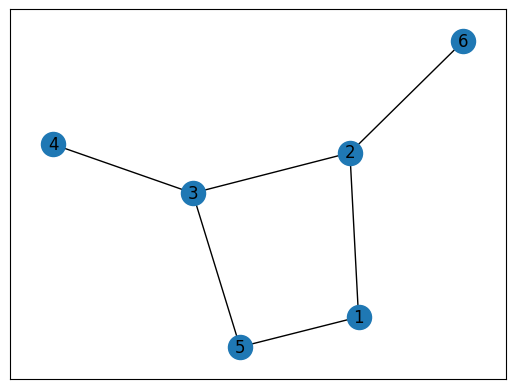

In [79]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
edge_list = [(1, 2), (3, 4), (2, 3), (1, 5), (3, 5), (2, 6)]
G.add_edges_from(edge_list)
nx.draw_networkx(G, with_labels=True)

{0: 2, 1: 5, 2: 2, 3: 3}
2


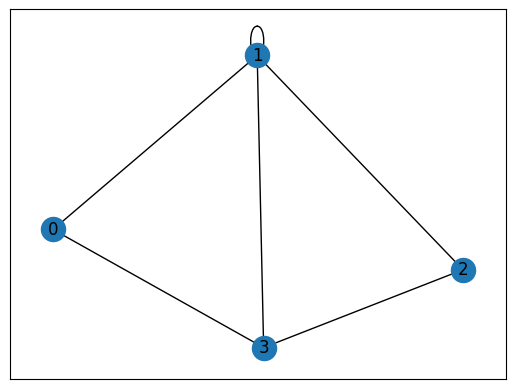

In [111]:
import numpy as np
adjm = np.array([[0, 1, 0, 1],
                [1, 1, 1, 1],
                [0, 1, 0, 1],
                [1, 1, 1, 0]])

distm = np.array([[50, 31, 27, 12],
                [31, 36, 5, 73],
                [27, 5, 33, 19],
                [12, 73, 19, 0]])

G = nx.from_numpy_array(adjm, distm)
nx.draw_networkx(G)
print(dict(G.degree))
print(nx.shortest_path_length(G, 0, 2))
# how do I add distances? edge_features? node_features? => use pytorch.geomtric for this!

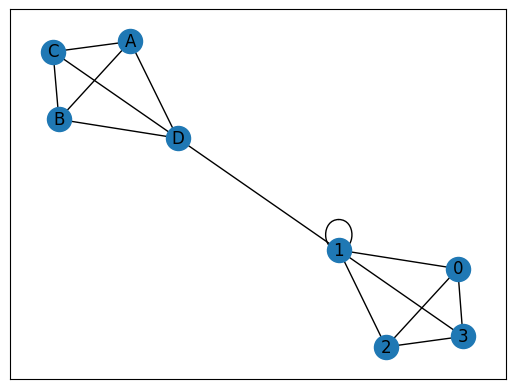

In [113]:
G1 = nx.complete_graph(4)
G1.add_edge(1, 1)
G2 = nx.complete_graph(4)
letter_map = {i: chr(65 + i) for i in range(0, 4)}
G2 = nx.relabel_nodes(G2, letter_map)
G_connect = nx.from_edgelist([(1, "D")])
G_total = nx.compose_all([G1, G2, G_connect])
nx.draw_networkx(G_total)


In [112]:
print(nx.degree_centrality(G_total))
print(nx.betweenness_centrality(G_total))
print(nx.density(G_total))
print(nx.diameter(G_total)) # longest shortest path
print(list(nx.bridges(G_total)))
# how do I remove edges?
G_total.remove_edge(1, "D")
G_total.remove_self
print(list(nx.connected_components(G_total)))

{0: 0.42857142857142855, 1: 0.5714285714285714, 2: 0.42857142857142855, 3: 0.42857142857142855, 'A': 0.42857142857142855, 'B': 0.42857142857142855, 'C': 0.42857142857142855, 'D': 0.5714285714285714}
{0: 0.0, 1: 0.5714285714285714, 2: 0.0, 3: 0.0, 'A': 0.0, 'B': 0.0, 'C': 0.0, 'D': 0.5714285714285714}
0.4642857142857143
3
[(1, 'D')]
[{0, 1, 2, 3}, {'C', 'A', 'D', 'B'}]
